In [1]:
#General
import numpy as np 
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

#Deep
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


## Load Data and Clean Outliers

In [0]:
training_features_csv = 'https://raw.githubusercontent.com/conditg/deng-ai/master/data/dengue_features_train.csv'
training_labels_csv = 'https://raw.githubusercontent.com/conditg/deng-ai/master/data/dengue_labels_train.csv'
test_features_csv = 'https://raw.githubusercontent.com/conditg/deng-ai/master/data/dengue_features_test.csv'
submission_csv = 'https://raw.githubusercontent.com/conditg/deng-ai/master/data/submission_format.csv'

In [0]:
rawfeats = pd.read_csv(training_features_csv)
trainl = pd.read_csv(training_labels_csv)
testfeats = pd.read_csv(test_features_csv)

#merge training labels and training data
rawfeats['total_cases'] = trainl['total_cases']


In [4]:
#Degrade outliers (See eda.ipynb for details)
#Essentially, soften outliers from training data
sj = rawfeats[rawfeats.city=='sj'].copy()
sjtest = testfeats[testfeats.city=='sj'].copy()
iq = rawfeats[rawfeats.city=='iq'].copy()
iqtest = testfeats[testfeats.city=='iq'].copy()
to_trim = ['ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']
            
for v in to_trim:
    sj.loc[:,v] = [min(x, sjtest[v].max()) for x in sj[v]]
    sj.loc[:,v] = [max(x, sjtest[v].min()) for x in sj[v]]
    iq.loc[:,v] = [min(x, iqtest[v].max()) for x in iq[v]]
    iq.loc[:,v] = [max(x, iqtest[v].min()) for x in iq[v]]

trainfeats = pd.concat([sj,iq])
trainfeats.shape

(1456, 25)

## San Juan Feature Engineering

In [0]:
sj = trainfeats[trainfeats.city == 'sj']

In [0]:
def process_sj(rawfeats, n_steps=3, test=False):
  #Fill nans
  feats = rawfeats.interpolate(method='linear')
  #Replace week 53 with week 52
  feats.loc[:,'weekofyear'] = np.where(feats.weekofyear > 52, 
                                       52, feats.weekofyear)
      #Scale then average temperature readings
  tempscols_to_average = feats.loc[:,['reanalysis_max_air_temp_k', 
    'station_avg_temp_c', 'reanalysis_avg_temp_k', 
    'reanalysis_min_air_temp_k','station_min_temp_c',
    'reanalysis_dew_point_temp_k', 'reanalysis_air_temp_k']]
  
  scaled_temps = MinMaxScaler().fit_transform(tempscols_to_average)
  scaled_temps = pd.DataFrame(scaled_temps, 
                            columns=tempscols_to_average.columns)
  feats.loc[:,'temps_mean'] = scaled_temps.mean(axis=1)
  
  cutoffs = [11, 30, 42]
  feats['fall'] = np.where((feats.weekofyear<cutoffs[0]), 1, 0)
  feats['winter'] = np.where((feats.weekofyear>=cutoffs[0]) &
                             (feats.weekofyear<cutoffs[1]), 1, 0)
  feats['summer'] = np.where((feats.weekofyear>=cutoffs[1]), 1, 0)  
  #drop unneeded columns
  keep = ['total_cases','winter', 'summer', 'fall', 'station_max_temp_c',
     'temps_mean', 'reanalysis_relative_humidity_percent',
     'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2']
  for col in feats.columns:
      if col not in keep:
          feats = feats.drop(col, axis=1)

  #Ensure the target variable is last, if using training data
  if not test:
    tc = feats.pop('total_cases')
    feats['total_cases'] = tc
    print(f'{feats.columns[-1]} is last')
  #Split into time sequences 
  arrfeats = feats.values
  seqs = []
  labels = []
  # Fill first test rows with the same data as the 3rd one, as they will not
  # have a real sequence otherwise
  if test:
    seqs.append([arrfeats[0,:],arrfeats[0,:],arrfeats[0,:]])
    seqs.append([arrfeats[0,:],arrfeats[0,:],arrfeats[1,:]])
  for i in range(len(arrfeats)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(arrfeats):
      break
    if not test:
      seq, seq_y = arrfeats[i:end_ix, :-1], arrfeats[end_ix-1, -1]
      labels.append(seq_y)
    else:
      seq = arrfeats[i:end_ix, :]
    seqs.append(seq)
  return np.array(seqs), np.array(labels)

In [7]:
sjseq, sjlabels = process_sj(sj)

total_cases is last


In [8]:
sjseq.shape

(934, 3, 8)

In [9]:
sjlabels.shape

(934,)

In [10]:
n_samples = len(sjseq) #number of sequences
sjseq.shape

(934, 3, 8)

##Training with Walk Forward Validation

In [11]:
n_train = 1 # minimum training size: one sequence of 3 weeks 
n_samples = len(sjseq) #number of sequences
sjseq.shape

(934, 3, 8)

In [12]:
#Testing the loop will size the walking windows correctly
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:,:] )
  test = np.array(sjlabels[:i])
  print(f'train={train.shape}, test={test.shape}')
  if i > n_train+10:
    print('etc...')
    break

train=(1, 3, 8), test=(1,)
train=(2, 3, 8), test=(2,)
train=(3, 3, 8), test=(3,)
train=(4, 3, 8), test=(4,)
train=(5, 3, 8), test=(5,)
train=(6, 3, 8), test=(6,)
train=(7, 3, 8), test=(7,)
train=(8, 3, 8), test=(8,)
train=(9, 3, 8), test=(9,)
train=(10, 3, 8), test=(10,)
train=(11, 3, 8), test=(11,)
train=(12, 3, 8), test=(12,)
etc...


In [0]:
def fit_lstm(train, labels, nb_epoch, neurons):
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(
                  1,#train.shape[0], #not sure which is right
                  train.shape[1], train.shape[2]),
                  stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  for i in range(nb_epoch):
    model.fit(train, labels, epochs=1, batch_size=1,#train.shape[0],
              verbose=0, shuffle=False)
    model.reset_states()
  return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
  yhat = model.predict(X, batch_size=batch_size)
  return yhat[0,0]

# Update LSTM model following a prediction
def update_model(model, train, label, batch_size, updates):
  for i in range(updates):
    for j, batch in enumerate(train):
      batch = np.array([batch])
      #print(f'batch size: {batch.shape}')
      model.fit(batch, np.array([label[j]]), epochs=1, batch_size=batch_size, 
                verbose=0, shuffle=False)
    model.reset_states()

### 16 nodes, LR=.01

In [0]:
seq3lstm16n10ep1every1=list()
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:,:] )
  labels = np.array(sjlabels[:i])
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, labels, 10, 16)
  else:
    #update the model with additional training point
    print(train.shape)
    update_model(lstm, train, labels, 1, 1)
  
  #predict
  x_validate = np.array([sjseq[i,:,:]])
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  seq3lstm16n10ep1every1.append(yhat)
  
  

In [17]:
rmse = sqrt(mean_squared_error(sjlabels[1:], seq3lstm16n10ep1every1))
print('Test RMSE: %.3f' % (rmse))

Test RMSE: 52.866


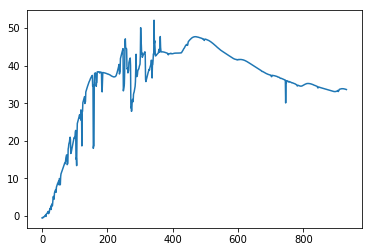

In [18]:
plt.plot(seq3lstm16n10ep1every1)

In [0]:
#Higher learning rate, as this model doesn't
#appear to be learning fast enough to react

### 16 nodes, LR=.1

In [0]:
adam = Adam(lr=.1)

def fit_lstm(train, labels, nb_epoch, neurons):
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(
                  1,#train.shape[0], #not sure which is right
                  train.shape[1], train.shape[2]),
                  stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer=adam)
  for i in range(nb_epoch):
    model.fit(train, labels, epochs=1, batch_size=1,#train.shape[0],
              verbose=0, shuffle=False)
    model.reset_states()
  return model

In [0]:
seq3lstm16n10ep1every1lr1 = list()

for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:,:] )
  labels = np.array(sjlabels[:i])
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, labels, 10, 16)
  else:
    #update the model
    print(train.shape)
    update_model(lstm, train, labels, 1, 1)
  
  #predict
  x_validate = np.array([sjseq[i,:,:]])
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  seq3lstm16n10ep1every1lr1.append(yhat)
  
  

Test RMSE: 52.040


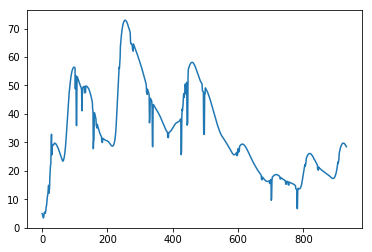

In [22]:
rmse = sqrt(mean_squared_error(sjlabels[1:], seq3lstm16n10ep1every1lr1))
print('Test RMSE: %.3f' % (rmse))
plt.plot(seq3lstm16n10ep1every1lr1)

In [0]:
#Looks promising, let's increase the size and see if we get higher peaks

### 64 nodes, LR=.1

In [0]:

seq3lstm64n10e1every1lr1 = list()

for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:,:] )
  labels = np.array(sjlabels[:i])
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, labels, 10, 64)
  else:
    #update the model
    print(train.shape)
    update_model(lstm, train, labels, 1, 2)
  
  #predict
  x_validate = np.array([sjseq[i,:,:]])
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  seq3lstm64n10e1every1lr1.append(yhat)
  
  

Test RMSE: 52.160


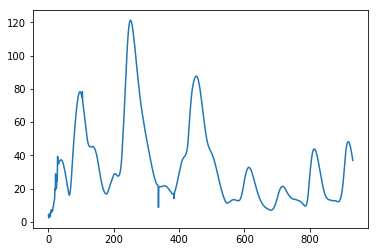

In [24]:
rmse = sqrt(mean_squared_error(sjlabels[1:], seq3lstm64n10e1every1lr1))
print('Test RMSE: %.3f' % (rmse))
plt.plot(seq3lstm64n10e1every1lr1)

In [0]:
#More nodes allowed higher predictions. Trying a larger layer:

### 128 nodes, LR=.1

In [0]:
seq3lstm128n10e1every1lr1 = list()

for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:,:] )
  labels = np.array(sjlabels[:i])
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, labels, 10, 128)
  else:
    #update the model
    print(train.shape)
    update_model(lstm, train, labels, 1, 2)
  
  #predict
  x_validate = np.array([sjseq[i,:,:]])
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  seq3lstm128n10e1every1lr1.append(yhat)
  
  

Test RMSE: 52.128


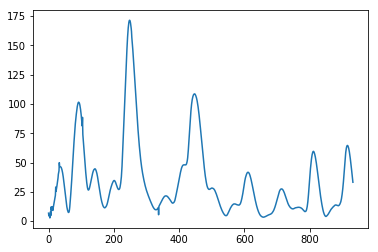

In [29]:
rmse = sqrt(mean_squared_error(sjlabels[1:], seq3lstm128n10e1every1lr1))
print('Test RMSE: %.3f' % (rmse))
plt.plot(seq3lstm128n10e1every1lr1)

In [0]:
#Still improving, double the network again:

### 128 nodes, LR=.1

In [0]:
#Going higher
seq3lstm256n10e1every1lr1 = list()

for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:,:] )
  labels = np.array(sjlabels[:i])
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, labels, 10, 256)
  else:
    #update the model
    update_model(lstm, train, labels, 1, 2)
  
  #predict
  x_validate = np.array([sjseq[i,:,:]])
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  seq3lstm256n10e1every1lr1.append(yhat)
  


Test RMSE: 50.452


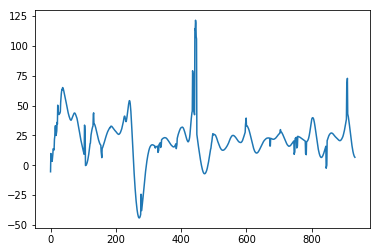

In [32]:
rmse = sqrt(mean_squared_error(sjlabels[1:], seq3lstm256n10e1every1lr1))
print('Test RMSE: %.3f' % (rmse))
plt.plot(seq3lstm256n10e1every1lr1)

## Summary of training progression

In [0]:
import matplotlib as mpl
mpl.style.use('seaborn-white')

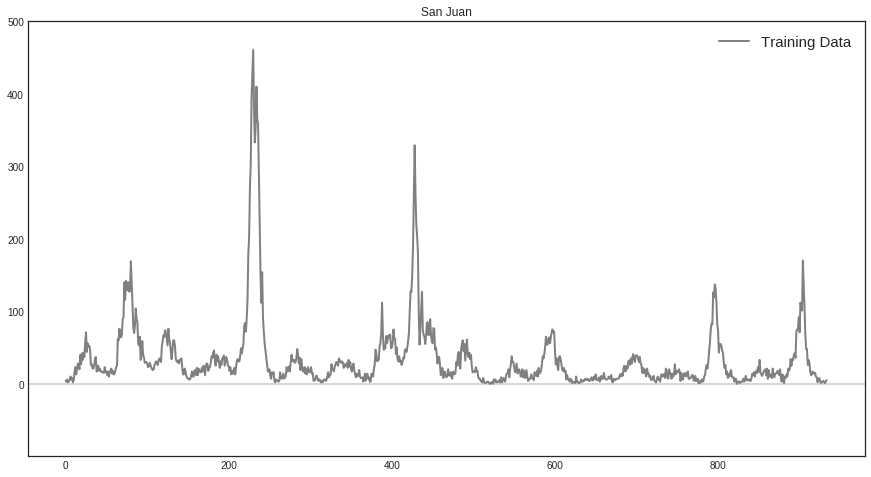

In [34]:

plt.figure(figsize=[15,8])
plt.title('San Juan')
plt.ylim([-100,500])
plt.yticks([0,100,200,300,400,500])
plt.axhline(0, color='#cccccc')
plt.plot(sjlabels, linewidth=2, label='Training Data', color='grey')
plt.legend(loc=1, framealpha=1, prop={'size': 15})
plt.show()


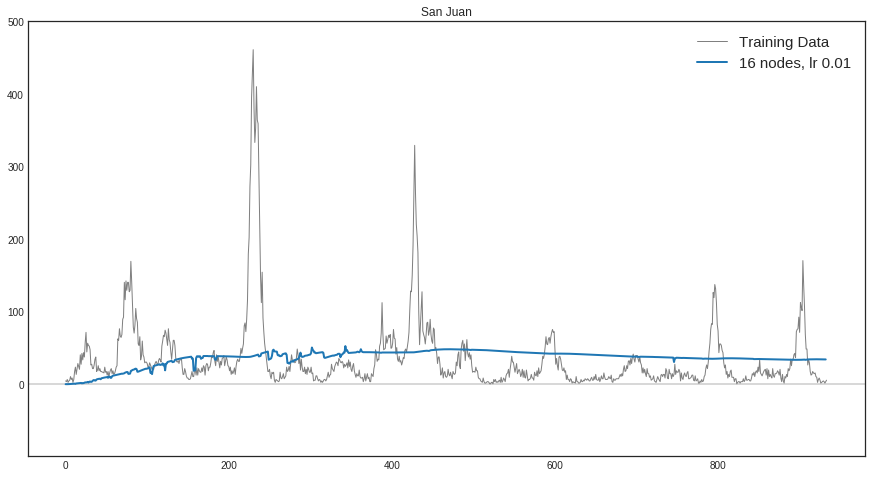

In [35]:
plt.figure(figsize=[15,8])
plt.title('San Juan')
plt.ylim([-100,500])
plt.yticks([0,100,200,300,400,500])
plt.axhline(0, color='#cccccc')
plt.plot(sjlabels, linewidth=1, label='Training Data', color='grey')
plt.plot(seq3lstm16n10ep1every1, label='16 nodes, lr 0.01', linewidth=2)
plt.legend(loc=1, framealpha=1, prop={'size': 15})
plt.show()

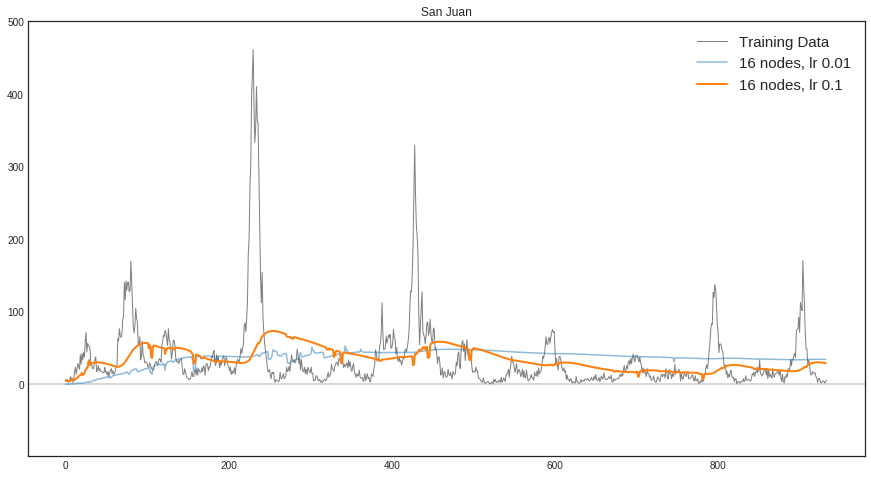

In [36]:
plt.figure(figsize=[15,8])
plt.title('San Juan')
plt.ylim([-100,500])
plt.yticks([0,100,200,300,400,500])
plt.axhline(0, color='#cccccc')
plt.plot(sjlabels, linewidth=1, label='Training Data', color='grey')
plt.plot(seq3lstm16n10ep1every1, label='16 nodes, lr 0.01', alpha=.5)
plt.plot(seq3lstm16n10ep1every1lr1, label='16 nodes, lr 0.1', linewidth=2)

plt.legend(loc=1, framealpha=1, prop={'size': 15})
plt.show()

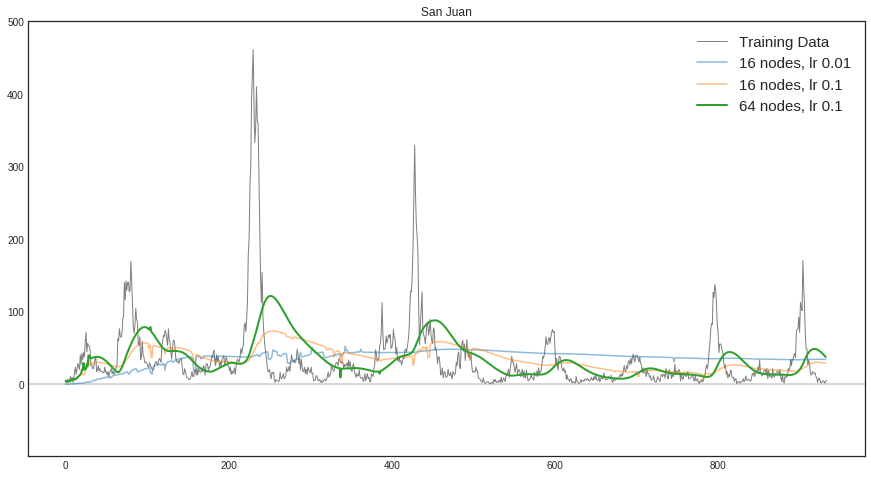

In [37]:
plt.figure(figsize=[15,8])
plt.title('San Juan')
plt.ylim([-100,500])
plt.yticks([0,100,200,300,400,500])
plt.axhline(0, color='#cccccc')
plt.plot(sjlabels, linewidth=1, label='Training Data', color='grey')
plt.plot(seq3lstm16n10ep1every1, label='16 nodes, lr 0.01', alpha=.5)
plt.plot(seq3lstm16n10ep1every1lr1, label='16 nodes, lr 0.1', alpha=.5)
plt.plot(seq3lstm64n10e1every1lr1, label='64 nodes, lr 0.1', linewidth=2)


plt.legend(loc=1, framealpha=1, prop={'size': 15})
plt.show()

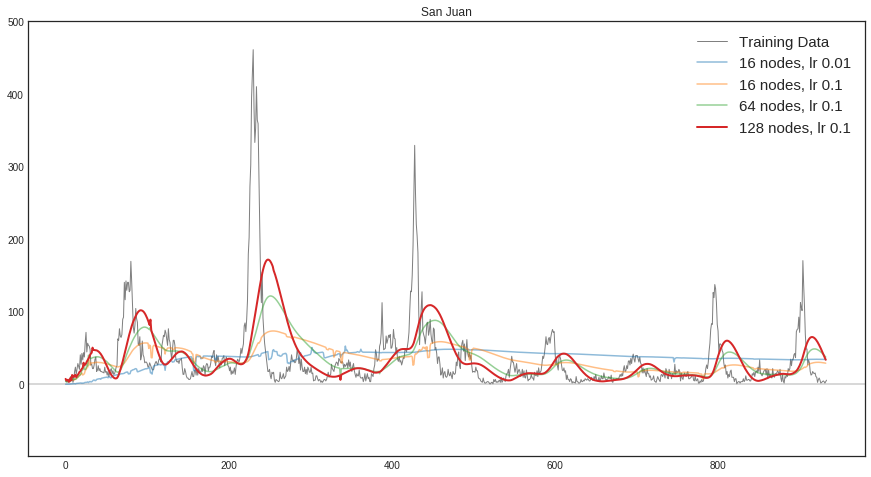

In [38]:
plt.figure(figsize=[15,8])
plt.title('San Juan')
plt.ylim([-100,500])
plt.yticks([0,100,200,300,400,500])
plt.axhline(0, color='#cccccc')
plt.plot(sjlabels, linewidth=1, label='Training Data', color='grey')
plt.plot(seq3lstm16n10ep1every1, label='16 nodes, lr 0.01', alpha=.5)
plt.plot(seq3lstm16n10ep1every1lr1, label='16 nodes, lr 0.1', alpha=.5)
plt.plot(seq3lstm64n10e1every1lr1, label='64 nodes, lr 0.1', alpha=.5)
plt.plot(seq3lstm128n10e1every1lr1, label='128 nodes, lr 0.1', linewidth=2)
plt.legend(loc=1, framealpha=1, prop={'size': 15})
plt.show()

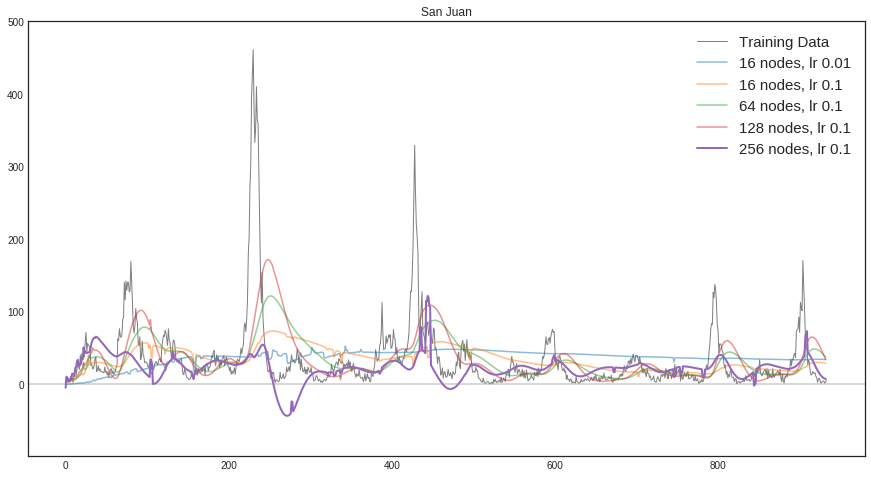

In [39]:
plt.figure(figsize=[15,8])
plt.title('San Juan')
plt.ylim([-100,500])
plt.yticks([0,100,200,300,400,500])
plt.axhline(0, color='#cccccc')
plt.plot(sjlabels, linewidth=1, label='Training Data', color='grey')
plt.plot(seq3lstm16n10ep1every1, label='16 nodes, lr 0.01', alpha=.5)
plt.plot(seq3lstm16n10ep1every1lr1, label='16 nodes, lr 0.1', alpha=.5)
plt.plot(seq3lstm64n10e1every1lr1, label='64 nodes, lr 0.1', alpha=.5)
plt.plot(seq3lstm128n10e1every1lr1, label='128 nodes, lr 0.1', alpha=.5)
plt.plot(seq3lstm256n10e1every1lr1, label='256 nodes, lr 0.1', linewidth=2)

plt.legend(loc=1, framealpha=1, prop={'size': 15})
plt.show()

------------
# Retrying without sequencing

This repeats the same process, but does not feed samples of 3 weeks in; rather, each x is only one week and the model trains on the whole available training set each time.

In [0]:
sj.head()

In [0]:
def process_sj_flat(rawfeats, test=False):
  #Fill nans
  feats = rawfeats.interpolate(method='linear')
  #Replace week 53 with week 52
  feats.loc[:,'weekofyear'] = np.where(feats.weekofyear > 52, 
                                       52, feats.weekofyear)
      #Scale then average temperature readings
  tempscols_to_average = feats.loc[:,['reanalysis_max_air_temp_k', 
    'station_avg_temp_c', 'reanalysis_avg_temp_k', 
    'reanalysis_min_air_temp_k','station_min_temp_c',
    'reanalysis_dew_point_temp_k', 'reanalysis_air_temp_k']]
  
  scaled_temps = MinMaxScaler().fit_transform(tempscols_to_average)
  scaled_temps = pd.DataFrame(scaled_temps, 
                            columns=tempscols_to_average.columns)
  feats.loc[:,'temps_mean'] = scaled_temps.mean(axis=1)
  
  cutoffs = [11, 30, 42]
  feats['fall'] = np.where((feats.weekofyear<cutoffs[0]), 1, 0)
  feats['winter'] = np.where((feats.weekofyear>=cutoffs[0]) &
                             (feats.weekofyear<cutoffs[1]), 1, 0)
  feats['summer'] = np.where((feats.weekofyear>=cutoffs[1]), 1, 0)  
  #drop unneeded columns
  keep = ['total_cases','winter', 'summer', 'fall', 'station_max_temp_c',
     'temps_mean', 'reanalysis_relative_humidity_percent',
     'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2']
  for col in feats.columns:
      if col not in keep:
          feats = feats.drop(col, axis=1)

  #Move the target variable is last, if using training data
  if not test:
    labels = feats.pop('total_cases')
  
  if test:
    #add last n rows of train data?
    pass
  
  return feats.values, labels

In [0]:
sjseq, sjlabels = process_sj_flat(sj)

In [0]:
sjseq.shape

In [0]:
sjlabels.shape

In [0]:
n_train = 4 # min of 4 weeks  to train
n_samples = len(sjseq) #number of sequences
sjseq.shape

In [0]:
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:] )
  test = np.array([sjlabels[i-1]])
  print(f'train={train.shape}, test={test.shape}')
  if i > n_train+10:
    print('etc...')
    break

In [0]:
def fit_lstm(train, label, batch_size, nb_epoch, neurons):
  #train = train.reshape(train.shape[0], 1, train.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(
                  batch_size, train.shape[1], train.shape[2]),
                  stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  for i in range(nb_epoch):
    model.fit(train, label, epochs=1, batch_size= batch_size,
              verbose=0, shuffle=False)
    model.reset_states()
  return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
  yhat = model.predict(X, batch_size=batch_size)
  return yhat[0,0]

# Update LSTM model
def update_model(model, train, label, batch_size, updates):
  for i in range(updates):
    model.fit(train, label, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

In [0]:
lstm32n200e1every1 = list()
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:] )
  train = train.reshape(train.shape[0], 1, train.shape[1])
  label = np.array([sjlabels[:i]]).transpose()
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, label, 1, 200, 32)
  else:
    #update the model
    update_model(lstm, train, label, 1, 3)
  
  #predict
  x_validate = np.array([sjseq[i,:]])
  x_validate = x_validate.reshape(1, x_validate.shape[0], x_validate.shape[1])
  
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  lstm32n200e1every1.append(yhat)
  
  

In [0]:
rmse = sqrt(mean_squared_error(sjlabels[4:], lstm32n200e1every1))
print('Test RMSE: %.3f' % (rmse))
plt.plot(predictions)

In [0]:
#16 nodes, 10 initial epochs and 1 epoch updates
lstm16n10e1every1 = list()
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:] )
  train = train.reshape(train.shape[0], 1, train.shape[1])
  label = np.array([sjlabels[:i]]).transpose()
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, label, 1, 10, 16)
  else:
    #update the model
    update_model(lstm, train, label, 1, 1)
  
  #predict
  x_validate = np.array([sjseq[i,:]])
  x_validate = x_validate.reshape(1, x_validate.shape[0], x_validate.shape[1])
  
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  lstm16n10e1every1.append(yhat)


In [0]:
rmse = sqrt(mean_squared_error(sjlabels[4:], lstm16n10e1every1))
print('Test RMSE: %.3f' % (rmse))
plt.plot(lstm16n10e1every1)
plt.show()

In [0]:
#32 nodes, 5 initial epochs and 1 epoch update on EVERY sample.
lstm32n5e1every1lr1 = list()
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:] )
  train = train.reshape(train.shape[0], 1, train.shape[1])
  label = np.array([sjlabels[:i]]).transpose()
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, label, 1, 5, 32)
  else:
    #update the model
    update_model(lstm, train, label, 1, 1)
  
  #predict
  x_validate = np.array([sjseq[i,:]])
  x_validate = x_validate.reshape(1, x_validate.shape[0], x_validate.shape[1])
  
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  lstm32n5e1every1lr1.append(yhat)

In [0]:
rmse = sqrt(mean_squared_error(sjlabels[4:], lstm32n5e1every1lr1))
print('Test RMSE: %.3f' % (rmse))
plt.plot(lstm32n5e1every1lr1)
plt.show()

In [0]:
#try a crazy high learning rate to try to capture the peak
adam = Adam(lr=0.5)
def fit_lstm(train, label, batch_size, nb_epoch, neurons):
  #train = train.reshape(train.shape[0], 1, train.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(
                  batch_size, train.shape[1], train.shape[2]),
                  stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer=adam)
  for i in range(nb_epoch):
    model.fit(train, label, epochs=1, batch_size= batch_size,
              verbose=0, shuffle=False)
    model.reset_states()
  return model

In [0]:
#16 nodes, 5 initial epochs and 1 epoch update on EVERY one.
lstm16n5e1every1lr5 = list()
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:] )
  train = train.reshape(train.shape[0], 1, train.shape[1])
  label = np.array([sjlabels[:i]]).transpose()
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, label, 1, 5, 16)
  else :
    #update the model
    update_model(lstm, train, label, 1, 1)
  
  #predict
  x_validate = np.array([sjseq[i,:]])
  x_validate = x_validate.reshape(1, x_validate.shape[0], x_validate.shape[1])
  
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  lstm16n5e1every1lr5.append(yhat)

In [0]:
rmse = sqrt(mean_squared_error(sjlabels[4:], lstm16n5e1every1lr5))
print('Test RMSE: %.3f' % (rmse))
plt.plot(lstm16n5e1every1lr5)
plt.show()


## Next I tried predicting multiple validation samples at a time to reduce epochs needed and speed up training. Unfortunately, this produced spastic validation predictions that were not reliable to interpret.

In [0]:
adam = Adam(lr=0.001)
#16 nodes, 10 initial epochs and 1 epoch update on EVERY OTHER.
predictions = list()
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:] )
  train = train.reshape(train.shape[0], 1, train.shape[1])
  label = np.array([sjlabels[:i]]).transpose()
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, label, 1, 10, 16)
  elif i %2 :
    #update the model
    update_model(lstm, train, label, 1, 1)
  
  #predict
  x_validate = np.array([sjseq[i,:]])
  x_validate = x_validate.reshape(1, x_validate.shape[0], x_validate.shape[1])
  
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  predictions.append(yhat)


In [0]:
plt.plot(predictions)

In [0]:
#16 nodes, 10 initial epochs and 1 epoch update on EVERY THIRD.
predictions = list()
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:] )
  train = train.reshape(train.shape[0], 1, train.shape[1])
  label = np.array([sjlabels[:i]]).transpose()
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, label, 1, 10, 16)
  elif not i%3 :
    #update the model
    update_model(lstm, train, label, 1, 1)
  
  #predict
  x_validate = np.array([sjseq[i,:]])
  x_validate = x_validate.reshape(1, x_validate.shape[0], x_validate.shape[1])
  
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  predictions.append(yhat)


In [0]:
plt.plot(predictions)

In [0]:
#16 nodes, 10 initial epochs and 1 epoch update on EVERY FIFTH.
predictions = list()
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:] )
  train = train.reshape(train.shape[0], 1, train.shape[1])
  label = np.array([sjlabels[:i]]).transpose()
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, label, 1, 10, 16)
  elif not i%5 :
    #update the model
    update_model(lstm, train, label, 1, 1)
  
  #predict
  x_validate = np.array([sjseq[i,:]])
  x_validate = x_validate.reshape(1, x_validate.shape[0], x_validate.shape[1])
  
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  predictions.append(yhat)


In [0]:
plt.plot(predictions)

##Updated to faster learning rate

In [0]:
adam = Adam(lr=0.01)
def fit_lstm(train, label, batch_size, nb_epoch, neurons):
  #train = train.reshape(train.shape[0], 1, train.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(
                  batch_size, train.shape[1], train.shape[2]),
                  stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer=adam)
  for i in range(nb_epoch):
    model.fit(train, label, epochs=1, batch_size= batch_size,
              verbose=0, shuffle=False)
    model.reset_states()
  return model

In [0]:
#16 nodes, 10 initial epochs and 1 epoch update on EVERY FIFTH.
predictions = list()
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:] )
  train = train.reshape(train.shape[0], 1, train.shape[1])
  label = np.array([sjlabels[:i]]).transpose()
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, label, 1, 10, 16)
  elif not i%5 :
    #update the model
    update_model(lstm, train, label, 1, 1)
  
  #predict
  x_validate = np.array([sjseq[i,:]])
  x_validate = x_validate.reshape(1, x_validate.shape[0], x_validate.shape[1])
  
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  predictions.append(yhat)


In [0]:
plt.plot(predictions)

In [0]:
#32 nodes, 5 initial epochs and 1 epoch update on EVERY FIFTH.
predictions = list()
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:] )
  train = train.reshape(train.shape[0], 1, train.shape[1])
  label = np.array([sjlabels[:i]]).transpose()
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, label, 1, 5, 32)
  elif not i%5 :
    #update the model
    update_model(lstm, train, label, 1, 1)
  
  #predict
  x_validate = np.array([sjseq[i,:]])
  x_validate = x_validate.reshape(1, x_validate.shape[0], x_validate.shape[1])
  
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  predictions.append(yhat)

In [0]:
plt.plot(predictions)

##Increasing learn rate again

In [0]:
adam = Adam(lr=0.1)
def fit_lstm(train, label, batch_size, nb_epoch, neurons):
  #train = train.reshape(train.shape[0], 1, train.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(
                  batch_size, train.shape[1], train.shape[2]),
                  stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer=adam)
  for i in range(nb_epoch):
    model.fit(train, label, epochs=1, batch_size= batch_size,
              verbose=0, shuffle=False)
    model.reset_states()
  return model

In [0]:
#32 nodes, 5 initial epochs and 1 epoch update on EVERY FIFTH.
predictions = list()
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:] )
  train = train.reshape(train.shape[0], 1, train.shape[1])
  label = np.array([sjlabels[:i]]).transpose()
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, label, 1, 5, 32)
  elif not i%5 :
    #update the model
    update_model(lstm, train, label, 1, 1)
  
  #predict
  x_validate = np.array([sjseq[i,:]])
  x_validate = x_validate.reshape(1, x_validate.shape[0], x_validate.shape[1])
  
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  predictions.append(yhat)

In [0]:
plt.plot(predictions)


In [0]:
#Let's overfit this with a high learn rate and a lot of epochs

In [0]:
#32 nodes, 5 initial epochs and 1 epoch update on EVERY OTHER.
predictions = list()
for i in range(n_train, n_samples):
  train = np.array(sjseq[:i,:] )
  train = train.reshape(train.shape[0], 1, train.shape[1])
  label = np.array([sjlabels[:i]]).transpose()
  if i == n_train:
    #initialize model the first time
    lstm = fit_lstm(train, label, 1, 5, 32)
  elif not i%2 :
    #update the model
    update_model(lstm, train, label, 1, 1)
  
  #predict
  x_validate = np.array([sjseq[i,:]])
  x_validate = x_validate.reshape(1, x_validate.shape[0], x_validate.shape[1])
  
  y_validate = sjlabels[i]
  yhat = forecast_lstm(lstm, 1, x_validate)
  predictions.append(yhat)

In [0]:
plt.figure(figsize=[35,5])
plt.plot(predictions)